In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image as PILImage
import cv2 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder # Can be an alternative if folders are structured correctly
from tqdm.notebook import tqdm # For progress bars (optional, install if needed)
import copy # To save best model weights

In [4]:
folder_path_Bacterial_spot = "/home/abdelrahmanelsayed/PC/My_Projects/CV/PlantVillage/Pepper__bell___Bacterial_spot"
folder_path_Healthy = "/home/abdelrahmanelsayed/PC/My_Projects/CV/PlantVillage/Pepper__bell___healthy"

# Get a list of all image file paths in the folder
image_files_Bacterial_spot = [os.path.join(folder_path_Bacterial_spot, file) for file in os.listdir(folder_path_Bacterial_spot) if file.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'gif'))]
image_files_Healthy = [os.path.join(folder_path_Healthy, file) for file in os.listdir(folder_path_Healthy) if file.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'gif'))]

# Create DataFrames
df_Bacterial_spot = pd.DataFrame(image_files_Bacterial_spot, columns=["File Path"])
df_Healthy = pd.DataFrame(image_files_Healthy, columns=["File Path"])

# Combine DataFrames
data = pd.concat([df_Bacterial_spot, df_Healthy], ignore_index=True)
# Keep string label for potential use later, but map to integer for PyTorch
data['Label_Str'] = ['Bacterial_spot'] * len(df_Bacterial_spot) + ['Healthy'] * len(df_Healthy)
label_map = {'Bacterial_spot': 0, 'Healthy': 1}
data['Label'] = data['Label_Str'].map(label_map)
data['Label'] = data['Label'].astype(int) # Keep as int for direct use
data['File Path'] = data['File Path'].astype(str)

# Shuffle the data
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

In [5]:
print("Combined DataFrame Head:")
print(data.head())
print("\nDataFrame Info:")
print(data.info())
print("\nValue Counts for Labels:")
print(data['Label_Str'].value_counts())

Combined DataFrame Head:
                                           File Path       Label_Str  Label
0  /home/abdelrahmanelsayed/PC/My_Projects/CV/Pla...  Bacterial_spot      0
1  /home/abdelrahmanelsayed/PC/My_Projects/CV/Pla...         Healthy      1
2  /home/abdelrahmanelsayed/PC/My_Projects/CV/Pla...  Bacterial_spot      0
3  /home/abdelrahmanelsayed/PC/My_Projects/CV/Pla...         Healthy      1
4  /home/abdelrahmanelsayed/PC/My_Projects/CV/Pla...         Healthy      1

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2475 entries, 0 to 2474
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   File Path  2475 non-null   object
 1   Label_Str  2475 non-null   object
 2   Label      2475 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 58.1+ KB
None

Value Counts for Labels:
Label_Str
Healthy           1478
Bacterial_spot     997
Name: count, dtype: int64



Image Dimension Statistics:
       Height   Width  Channels
count  2475.0  2475.0    2475.0
mean    256.0   256.0       3.0
std       0.0     0.0       0.0
min     256.0   256.0       3.0
25%     256.0   256.0       3.0
50%     256.0   256.0       3.0
75%     256.0   256.0       3.0
max     256.0   256.0       3.0

Unique Image Dimensions (Height, Width): [[256 256]]

All images have the same dimensions.

Unique Channel Counts:
Channels
3    2475
Name: count, dtype: int64


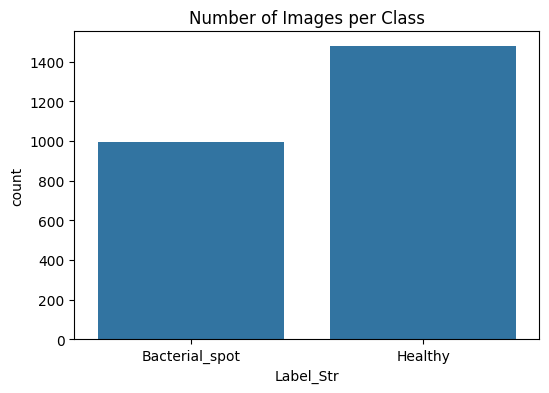

Label_Str
Healthy           1478
Bacterial_spot     997
Name: count, dtype: int64


In [6]:
image_dims = []
error_files = []
for file_path in data['File Path']:
    try:
        img = cv2.imread(file_path)
        if img is not None:
            image_dims.append(img.shape)
        else:
            print(f"Warning: Could not read image {file_path} with OpenCV. Skipping.")
            error_files.append(file_path)
    except Exception as e:
        print(f"Error reading image {file_path}: {e}")
        error_files.append(file_path)

if error_files:
    print(f"\nRemoving {len(error_files)} files that could not be read.")
    data = data[~data['File Path'].isin(error_files)].reset_index(drop=True)

dims_df = pd.DataFrame(image_dims, columns=['Height', 'Width', 'Channels'])
print("\nImage Dimension Statistics:")
print(dims_df.describe())
unique_dims = dims_df[['Height', 'Width']].drop_duplicates().values
print("\nUnique Image Dimensions (Height, Width):", unique_dims)
if len(unique_dims) > 1:
    print("\nWarning: Images have varying dimensions. Resizing will be necessary.")
else:
    print("\nAll images have the same dimensions.")
print("\nUnique Channel Counts:")
print(dims_df['Channels'].value_counts())
if (dims_df['Channels'] != 3).any():
     print("Warning: Not all images are 3-channel (RGB). Check/convert non-RGB images.")

plt.figure(figsize=(6, 4))
sns.countplot(x='Label_Str', data=data)
plt.title('Number of Images per Class')
plt.show()
print(data['Label_Str'].value_counts())

In [7]:
train_df, temp_df = train_test_split(
    data, test_size=0.30, random_state=42, stratify=data['Label'])

val_df, test_df = train_test_split(
    temp_df, test_size=0.50, random_state=42, stratify=temp_df['Label'])

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

Training samples: 1732
Validation samples: 371
Test samples: 372


In [8]:
class PlantDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        """
        Args:
            dataframe (pd.DataFrame): DataFrame with 'File Path' and 'Label' columns.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.dataframe.iloc[idx]['File Path']
        try:
            # Use PIL for compatibility with torchvision transforms
            image = PILImage.open(img_path).convert('RGB') # Ensure 3 channels
        except Exception as e:
            print(f"Error loading image {img_path}: {e}. Returning None.")
            image = PILImage.open(img_path).convert('RGB')


        label = self.dataframe.iloc[idx]['Label']
        label = torch.tensor(label, dtype=torch.float32) # BCELoss expects float target

        if self.transform:
            image = self.transform(image)

        return image, label 

In [9]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
BATCH_SIZE = 32
EPOCHS = 30
LEARNING_RATE = 0.0001
PATIENCE = 5 

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [10]:
train_transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop((IMG_HEIGHT, IMG_WIDTH), scale=(0.8, 1.0)), 
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [11]:
train_dataset = PlantDataset(train_df, transform=train_transform)
val_dataset = PlantDataset(val_df, transform=val_test_transform)
test_dataset = PlantDataset(test_df, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

In [12]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=1):
        super(SimpleCNN, self).__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )

        flattened_size = 128 * (IMG_HEIGHT // 8) * (IMG_WIDTH // 8)

        self.fc_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_size, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes) 
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.fc_block(x)
        return x

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [14]:
model = SimpleCNN(num_classes=1).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [15]:
best_val_accuracy = 0.0
epochs_no_improve = 0
best_model_weights = None # Store best weights here
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(EPOCHS):
    # --- Training Phase ---
    model.train() # Set model to training mode (enables dropout, batch norm updates)
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]", leave=False)
    for inputs, labels in train_pbar:
        inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1) # Add dimension for BCEWithLogitsLoss

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        # Apply sigmoid and threshold for accuracy calculation
        preds = torch.sigmoid(outputs) > 0.5
        correct_predictions += (preds == labels.byte()).sum().item() # Use byte for bool comparison
        total_samples += labels.size(0)

        train_pbar.set_postfix({'loss': loss.item()})

    epoch_train_loss = running_loss / total_samples
    epoch_train_acc = correct_predictions / total_samples
    history['train_loss'].append(epoch_train_loss)
    history['train_acc'].append(epoch_train_acc)

    # --- Validation Phase ---
    model.eval() # Set model to evaluation mode (disables dropout, uses running stats for batch norm)
    running_val_loss = 0.0
    correct_val_predictions = 0
    total_val_samples = 0

    val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Validate]", leave=False)
    with torch.no_grad(): # Disable gradient calculations
        for inputs, labels in val_pbar:
            inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item() * inputs.size(0)
            preds = torch.sigmoid(outputs) > 0.5
            correct_val_predictions += (preds == labels.byte()).sum().item()
            total_val_samples += labels.size(0)
            val_pbar.set_postfix({'val_loss': loss.item()})

    epoch_val_loss = running_val_loss / total_val_samples
    epoch_val_acc = correct_val_predictions / total_val_samples
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(epoch_val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} => "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

    # --- Model Checkpoint & Early Stopping ---
    if epoch_val_acc > best_val_accuracy:
        print(f"Validation accuracy improved ({best_val_accuracy:.4f} --> {epoch_val_acc:.4f}). Saving model...")
        best_val_accuracy = epoch_val_acc
        # Save the best model state
        best_model_weights = copy.deepcopy(model.state_dict())
        torch.save(best_model_weights, 'best_pepper_classifier_pytorch.pth')
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"Validation accuracy did not improve for {epochs_no_improve} epoch(s).")

    if epochs_no_improve >= PATIENCE:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break
    
if best_model_weights:
    print("Loading best model weights for final evaluation.")
    model.load_state_dict(best_model_weights)
else:
     print("Warning: No best model weights saved (perhaps training stopped early or didn't improve). Using last epoch weights.")

Epoch 1/30 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 1/30 [Validate]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 1/30 => Train Loss: 0.3762, Train Acc: 0.8262 | Val Loss: 0.3246, Val Acc: 0.8625
Validation accuracy improved (0.0000 --> 0.8625). Saving model...


Epoch 2/30 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 2/30 [Validate]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 2/30 => Train Loss: 0.2524, Train Acc: 0.8967 | Val Loss: 0.2342, Val Acc: 0.9407
Validation accuracy improved (0.8625 --> 0.9407). Saving model...


Epoch 3/30 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 3/30 [Validate]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 3/30 => Train Loss: 0.2104, Train Acc: 0.9232 | Val Loss: 0.2619, Val Acc: 0.9164
Validation accuracy did not improve for 1 epoch(s).


Epoch 4/30 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 4/30 [Validate]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 4/30 => Train Loss: 0.1664, Train Acc: 0.9376 | Val Loss: 0.2193, Val Acc: 0.9596
Validation accuracy improved (0.9407 --> 0.9596). Saving model...


Epoch 5/30 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 5/30 [Validate]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 5/30 => Train Loss: 0.1239, Train Acc: 0.9579 | Val Loss: 0.2420, Val Acc: 0.9596
Validation accuracy did not improve for 1 epoch(s).


Epoch 6/30 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 6/30 [Validate]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 6/30 => Train Loss: 0.1178, Train Acc: 0.9613 | Val Loss: 0.2161, Val Acc: 0.9623
Validation accuracy improved (0.9596 --> 0.9623). Saving model...


Epoch 7/30 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 7/30 [Validate]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 7/30 => Train Loss: 0.0844, Train Acc: 0.9729 | Val Loss: 0.2096, Val Acc: 0.9757
Validation accuracy improved (0.9623 --> 0.9757). Saving model...


Epoch 8/30 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 8/30 [Validate]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 8/30 => Train Loss: 0.0915, Train Acc: 0.9723 | Val Loss: 0.2341, Val Acc: 0.9704
Validation accuracy did not improve for 1 epoch(s).


Epoch 9/30 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 9/30 [Validate]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 9/30 => Train Loss: 0.0793, Train Acc: 0.9740 | Val Loss: 0.2147, Val Acc: 0.9784
Validation accuracy improved (0.9757 --> 0.9784). Saving model...


Epoch 10/30 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 10/30 [Validate]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 10/30 => Train Loss: 0.0526, Train Acc: 0.9827 | Val Loss: 0.2758, Val Acc: 0.9623
Validation accuracy did not improve for 1 epoch(s).


Epoch 11/30 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 11/30 [Validate]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 11/30 => Train Loss: 0.0590, Train Acc: 0.9786 | Val Loss: 0.2430, Val Acc: 0.9730
Validation accuracy did not improve for 2 epoch(s).


Epoch 12/30 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 12/30 [Validate]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 12/30 => Train Loss: 0.0585, Train Acc: 0.9809 | Val Loss: 0.3252, Val Acc: 0.9596
Validation accuracy did not improve for 3 epoch(s).


Epoch 13/30 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 13/30 [Validate]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 13/30 => Train Loss: 0.0393, Train Acc: 0.9890 | Val Loss: 0.2490, Val Acc: 0.9811
Validation accuracy improved (0.9784 --> 0.9811). Saving model...


Epoch 14/30 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 14/30 [Validate]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 14/30 => Train Loss: 0.0414, Train Acc: 0.9867 | Val Loss: 0.2527, Val Acc: 0.9838
Validation accuracy improved (0.9811 --> 0.9838). Saving model...


Epoch 15/30 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 15/30 [Validate]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 15/30 => Train Loss: 0.0293, Train Acc: 0.9913 | Val Loss: 0.2255, Val Acc: 0.9892
Validation accuracy improved (0.9838 --> 0.9892). Saving model...


Epoch 16/30 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 16/30 [Validate]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 16/30 => Train Loss: 0.0301, Train Acc: 0.9896 | Val Loss: 0.2141, Val Acc: 0.9865
Validation accuracy did not improve for 1 epoch(s).


Epoch 17/30 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 17/30 [Validate]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 17/30 => Train Loss: 0.0239, Train Acc: 0.9919 | Val Loss: 0.2468, Val Acc: 0.9892
Validation accuracy did not improve for 2 epoch(s).


Epoch 18/30 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 18/30 [Validate]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 18/30 => Train Loss: 0.0349, Train Acc: 0.9902 | Val Loss: 0.2601, Val Acc: 0.9811
Validation accuracy did not improve for 3 epoch(s).


Epoch 19/30 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 19/30 [Validate]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 19/30 => Train Loss: 0.0263, Train Acc: 0.9896 | Val Loss: 0.3669, Val Acc: 0.9488
Validation accuracy did not improve for 4 epoch(s).


Epoch 20/30 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 20/30 [Validate]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 20/30 => Train Loss: 0.0268, Train Acc: 0.9913 | Val Loss: 0.2575, Val Acc: 0.9892
Validation accuracy did not improve for 5 epoch(s).
Early stopping triggered after 20 epochs.
Loading best model weights for final evaluation.


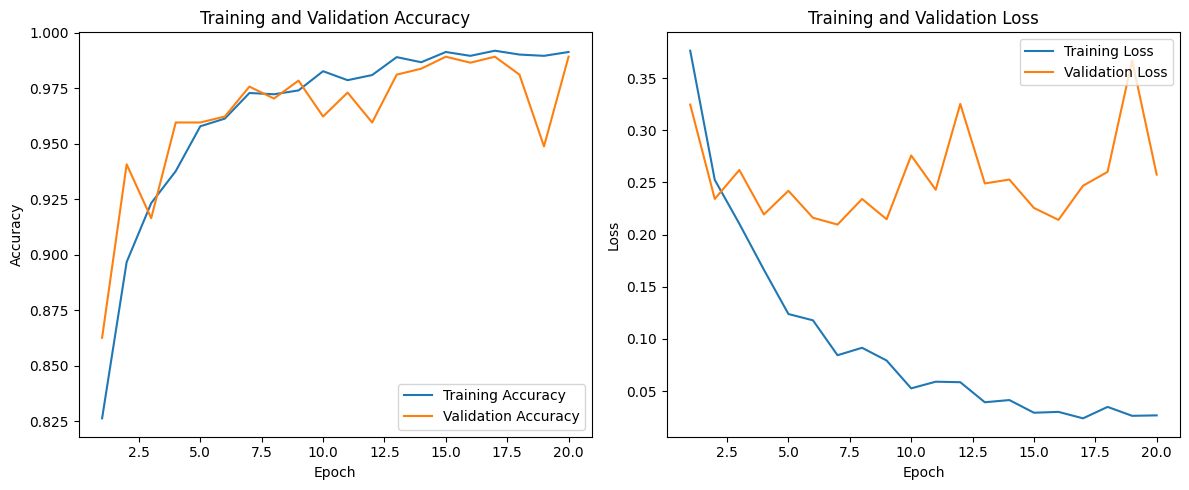

In [16]:
epochs_range = range(1, len(history['train_loss']) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history['train_acc'], label='Training Accuracy')
plt.plot(epochs_range, history['val_acc'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


plt.subplot(1, 2, 2)
plt.plot(epochs_range, history['train_loss'], label='Training Loss')
plt.plot(epochs_range, history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

In [17]:
model.eval()

all_preds = []
all_labels = []
test_loss = 0.0
total_test_samples = 0

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)

        outputs = model(inputs)
        loss = criterion(outputs, labels) # Calculate loss on test set as well

        test_loss += loss.item() * inputs.size(0)
        total_test_samples += labels.size(0)

        # Get predictions
        preds = torch.sigmoid(outputs) > 0.5
        all_preds.extend(preds.cpu().numpy()) # Move predictions to CPU and store
        all_labels.extend(labels.cpu().numpy()) # Move labels to CPU and store

final_test_loss = test_loss / total_test_samples
# Flatten lists for scikit-learn metrics
all_preds = np.array(all_preds).flatten().astype(int)
all_labels = np.array(all_labels).flatten().astype(int)

final_test_accuracy = accuracy_score(all_labels, all_preds)

print(f"\nTest Loss: {final_test_loss:.4f}")
print(f"Test Accuracy: {final_test_accuracy:.4f}")

Testing:   0%|          | 0/12 [00:00<?, ?it/s]


Test Loss: 0.0136
Test Accuracy: 0.9973



Classification Report:
                precision    recall  f1-score   support

Bacterial_spot       1.00      0.99      1.00       150
       Healthy       1.00      1.00      1.00       222

      accuracy                           1.00       372
     macro avg       1.00      1.00      1.00       372
  weighted avg       1.00      1.00      1.00       372


Confusion Matrix:
[[149   1]
 [  0 222]]


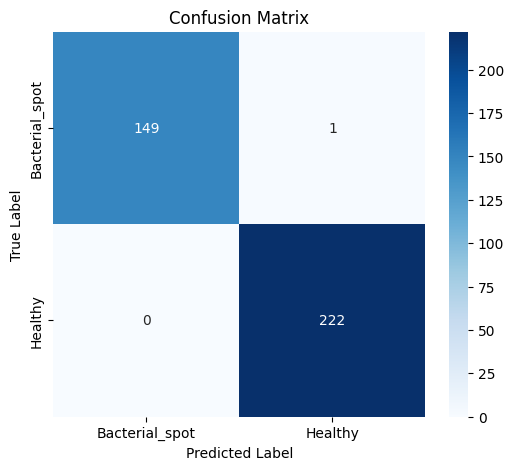

In [18]:
class_labels = list(label_map.keys())

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_labels))

print("\nConfusion Matrix:")
cm = confusion_matrix(all_labels, all_preds)
print(cm)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()